# Heston 

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from heston_model import *
import scipy.stats as stats
from numpy.random import default_rng, SeedSequence
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt


In [19]:
idx = pd.IndexSlice

# test semi-closed form solution

* In this part, we test the implementation of the semi-closed formula, by choosing the parameter sigma (the vol of vol) almost equal to zero, in this case the Call should have the same value as that in the Black-Sholes model

In [20]:


"""
implement the pricing formule of Call in Black-Sholes model

"""
def d_plus(s,k,v):
    return np.log(s/k)/np.sqrt(v) + np.sqrt(v)/2

def d_minus(s,k,v):
    return np.log(s/k)/np.sqrt(v) - np.sqrt(v)/2
def Call(K,r = 0.05,q = 0, sigma = 0.3,S_0 = 100, T = 1.5):
    K_dc = K*np.exp(-r*T)
    S_f = S_0*np.exp(-q*T)
    return S_f*stats.norm.cdf(d_plus(S_f,K_dc,sigma**2*T))-K_dc*stats.norm.cdf(d_minus(S_f,K_dc,sigma**2*T))

In [21]:
params = {
    'T': 5.,
    'r': 0.05,
    'theta': 0.1,
    'k': 1,
    'sigma': 0.00001,
    'rho': 0,
    's0' : 1.0,
    'v0': 0.1
}

In [22]:
params_test = {
    'T': 5,
    'r': 0.05,
    'sigma': np.sqrt(0.1),
    'S_0': 1.,
    'K': 1
}

In [23]:
"""
the assertion doesn't show in the output of the cell, which means that in this case the price of Call computed in Black_Sholes and Heston coinccide 
"""

model = Heston(**params)
assert np.isclose(Call(**params_test),model.call(1) )

c:\Users\xziru\OneDrive - Ecole Polytechnique\Paris 6\période 2\projet Monte-Carlos\project-Monte-Carlo\heston_model.py:183: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return  (0.5 + (1 / np.pi) * quad(integrand_1, 0, 100)[0]), (0.5 + (1 / np.pi) * quad(integrand_2, 0, 100)[0])
c:\Users\xziru\OneDrive - Ecole Polytechnique\Paris 6\période 2\projet Monte-Carlos\project-Monte-Carlo\heston_model.py:183: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return  (0.5 + (1 / np.pi) * quad(integrand_1, 0, 100)[0]), (0.5 + (1 / np.pi) * quad(integrand_2, 0, 100)[0])


# test schema 

In [24]:
sq = SeedSequence()
rng = default_rng(sq)

In [25]:
all_schema = ["implicit_3", "implicit_4", "E_lambda", "E_0", "Diop", "D-D"]

In [26]:
params = {
    'T': 5.,
    'r': 0.05,
    'theta': 0.1,
    'k': 1.1,
    'sigma': 0.4,
    'rho': -0.6,
    's0' : 1.0,
    'v0': 0.1
}

In [27]:
"""
a function that compute the confidence interval of the Monte-Carlos 

sample (numpy.array): the i.i.d sample simulated
proba (float): the level to compute the confident interval
"""
def monte_carlo(sample, proba=0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    quantile = sps.norm.ppf(1 - (1-proba)/2)
    ci_size = quantile * np.sqrt(var / sample.size)    
    result = pd.Series(
        [mean, var, mean - ci_size, mean + ci_size], 
        index=["Mean","Var","Lower bound", "Upper bound"] )
    return result

In [28]:
"""
a function that compute the confidence interval of the Monte-Carlos 

heston (class Heston): an object of the the class Heston

scheme_types (list (str)): a list of schema types used to compute

steps (int): the number of parts that are divided by discretization


"""

def compute_call_heston(heston, scheme_types, steps, K, M = 10000):
    results = pd.DataFrame(index = ["Mean","Var","Lower bound", "Upper bound"], 
                           columns=pd.MultiIndex.from_product([scheme_types, steps], names=['type', 'step']), dtype=float)
    

    for N in steps:
        dW1 = np.sqrt(heston.T / N) * rng.standard_normal((N, M))
        dW2 = np.sqrt(heston.T / N) * rng.standard_normal((N, M))
        for scheme_type in scheme_types:
            paths, vol = heston.paths_euler(scheme_type,dW1, dW2)
            payoffs = np.exp(-heston.r * heston.T)* np.maximum(paths[N] - K, 0)
            results.loc[:,(scheme_type, N)] = monte_carlo(payoffs)
    # results = results.T
    return results.T.assign(step_width = lambda df: 1/df.index.get_level_values('step').to_numpy())

In [29]:
heston = Heston(**params)
K = 0.5
M = int(1e6)
exact_price = heston.call(K)

In [30]:
exact_price

0.6345625199951872

In [31]:
step_width = np.linspace(0.01,0.4,20)
steps = np.unique(np.round(1/step_width).astype(int))

In [32]:
# steps = 2**np.arange(1,8)
results = compute_call_heston(heston, ["implicit_3", "E_0", "Diop","implicit_4"], steps, K = 0.5, M=M)

In [33]:
"""
a function to plot the Monte-Carlos simulation result
df (dataframe): the df contains all the information of the Monte-Carlos result
idx (int): an index used to change the color of the curve
zoom (float): keep on the part on interval [0, zoom] 
"""
def plot_confidence_interval(df,idx,zoom = False):
    name, df = df
    if zoom:
        df = df[df.step_width < zoom]
    color = f'C{idx}'
    step_width, m, up, down = (df.step_width.to_numpy(),df.Mean.to_numpy(), df['Upper bound'].to_numpy(),df['Lower bound'].to_numpy())
    # plt.plot(step_width, df.Mean)
    plt.plot(step_width, m, color=color, label=name)
    plt.plot(step_width, up, color=color, alpha=0.2)
    plt.plot(step_width, down, color=color, alpha=0.2)
    plt.fill_between(step_width, up, down, color=color, alpha=0.2)
    plt.plot(step_width, exact_price*np.ones(len(step_width)), color='grey')

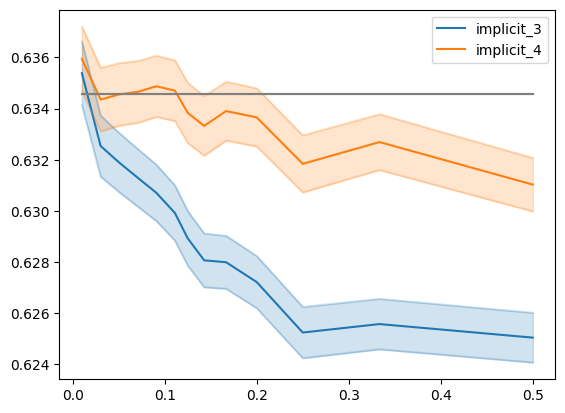

In [34]:
for idxs, df in enumerate(results.loc[idx[['implicit_4', 'implicit_3'],:],:].groupby(level=0)):
    plot_confidence_interval(df,idxs,)
    plt.legend()


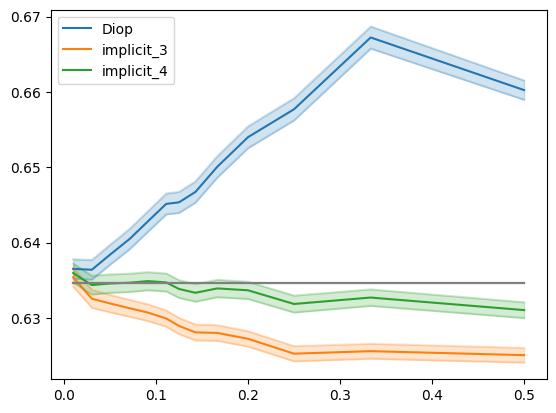

In [35]:
for idxs, df in enumerate(results.loc[idx[['implicit_4', 'implicit_3','Diop'],:],:].groupby(level=0)):
    plot_confidence_interval(df,idxs)
    plt.legend()
